In [1]:
import pandas as pd
import numpy as np
import GEOparse
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
%matplotlib inline


Загружаю данные об эксперименте

In [2]:
gse = GEOparse.get_GEO('GSE26728')

04-Apr-2020 17:38:01 DEBUG utils - Directory ./ already exists. Skipping.
04-Apr-2020 17:38:01 INFO GEOparse - File already exist: using local version.
04-Apr-2020 17:38:01 INFO GEOparse - Parsing ./GSE26728_family.soft.gz: 
04-Apr-2020 17:38:01 DEBUG GEOparse - DATABASE: GeoMiame
04-Apr-2020 17:38:01 DEBUG GEOparse - SERIES: GSE26728
04-Apr-2020 17:38:01 DEBUG GEOparse - PLATFORM: GPL7042
/home/neobird/snap/jupyter/common/lib/python3.7/site-packages/GEOparse/GEOparse.py:104: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  return parse_GSE(filepath)
04-Apr-2020 17:38:02 DEBUG GEOparse - SAMPLE: GSM658075
04-Apr-2020 17:38:02 DEBUG GEOparse - SAMPLE: GSM658076
04-Apr-2020 17:38:03 DEBUG GEOparse - SAMPLE: GSM658077
04-Apr-2020 17:38:03 DEBUG GEOparse - SAMPLE: GSM658078
04-Apr-2020 17:38:03 DEBUG GEOparse - SAMPLE: GSM658079
04-Apr-2020 17:38:03 DEBUG GEOparse - SAMPLE: GSM658080
04-Apr-2020 17:38:03 DEBUG GEOparse - SAMPLE: GSM658081

In [3]:
controls = ['GSM658075',
            'GSM658076',
            'GSM658077',
            'GSM658078',
            'GSM658079',
            'GSM658080']

low = ['GSM658081',
      'GSM658082',
      'GSM658083',
      'GSM658084',
      'GSM658085',
      'GSM658086']

high = ['GSM658087',
       'GSM658088',
       'GSM658089',
       'GSM658090',
       'GSM658091',
       'GSM658092']

## Информация о каком количестве генов есть в исследовании? Есть ли в данных дубликаты по генам? Что еще вы можете сказать о данных?

### 1) Проверить, нет ли дупликатов по генам в образцах.

Но прежде всего стоит проверить, нет ли в данных пропущенных значений.

In [4]:
gse.pivot_samples('VALUE').isnull().values.any()

False

Пропущенных значений нет.

Согласно [протоколу](https://www.ncbi.nlm.nih.gov/geo/info/platform.html) для GEO, ID_REF должны быть уникальными в таблице. Для каждого значения ID_REF с помощью некоторых тулов (например, [g:Convert](http://biit.cs.ut.ee/gprofiler/convert)) можно получить информацию о соответствующем гене в базе [ensembl](ensembl.org).
Проверю, действительно ли они уникальны.

In [5]:
for sample in gse.gsms:
    if not gse.gsms[sample].table['ID_REF'].duplicated().any():
        print('There is not dupl in {}'.format(sample))
    else:
        print('WARNING! There is dupl in {}!!!'.format(sample))

There is not dupl in GSM658075
There is not dupl in GSM658076
There is not dupl in GSM658077
There is not dupl in GSM658078
There is not dupl in GSM658079
There is not dupl in GSM658080
There is not dupl in GSM658081
There is not dupl in GSM658082
There is not dupl in GSM658083
There is not dupl in GSM658084
There is not dupl in GSM658085
There is not dupl in GSM658086
There is not dupl in GSM658087
There is not dupl in GSM658088
There is not dupl in GSM658089
There is not dupl in GSM658090
There is not dupl in GSM658091
There is not dupl in GSM658092


Можно сразу для удобства составить общую табличку по контрольным, low dose и high dose образцам. И проверить, одинаковый ли у них набор ID_REF

In [6]:
control_df = gse.pivot_samples('VALUE')[controls].reset_index()
low_df = gse.pivot_samples('VALUE')[low].reset_index()
high_df = gse.pivot_samples('VALUE')[high].reset_index()
(list(control_df.index) == list(low_df.index)) & \
(list(control_df.index) == list(high_df.index)) & \
(list(low_df.index) == list(high_df.index))

True

Дупликатов по ID нет, но стоит проверить, не могут ли несколько ID соответствовать одному и тому же гену. Названия у генов по определению уникальны. Используя данные о платформе из источника данных и [сервис](https://www.ncbi.nlm.nih.gov/geo/browse/?view=platforms&tool=findplatform) найду данные о том, какому гену соответствует какая ячейка.

In [7]:
ids = pd.read_csv('GPL7042-9573.txt', sep='\t', dtype='str')

Можно использовать одну из таблиц для одной экспериментальной группы, т.к. там одинаковый набор ID_REF. В экспериментальных данных заменю значения ID_REF на значения названий генов.

In [8]:
control_df.head()

name,ID_REF,GSM658075,GSM658076,GSM658077,GSM658078,GSM658079,GSM658080
0,A_51_P100034,12.630,11.899,12.393,12.539,12.368,12.361
1,A_51_P100063,5.828,6.598,5.984,5.986,6.089,6.163
2,A_51_P100099,7.638,7.635,7.216,7.767,7.516,7.378
3,A_51_P100155,10.947,10.582,10.406,11.054,10.770,10.402
4,A_51_P100174,6.632,6.089,6.012,6.190,6.260,6.131


In [9]:
ids_dict = defaultdict(list)
for _, row in ids.iterrows():
    ids_dict[row['SPOT_ID']] = row['GENE_SYMBOL']

In [10]:
def id_to_name(df, ids_dict):
    for i in df.index:
        df.at[i, 'gene'] = ids_dict[df.at[i, 'ID_REF']]

id_to_name(control_df, ids_dict)

control_df.head()

name,ID_REF,GSM658075,GSM658076,GSM658077,GSM658078,GSM658079,GSM658080,gene
0,A_51_P100034,12.630,11.899,12.393,12.539,12.368,12.361,Mif4gd
1,A_51_P100063,5.828,6.598,5.984,5.986,6.089,6.163,Lnx1
2,A_51_P100099,7.638,7.635,7.216,7.767,7.516,7.378,2610002J23Rik
3,A_51_P100155,10.947,10.582,10.406,11.054,10.770,10.402,Rpf1
4,A_51_P100174,6.632,6.089,6.012,6.190,6.260,6.131,Mns1


Теперь можно проверить, нет ли дупликатов по генам.

In [11]:
control_df.duplicated(subset='gene').any()

True

Да, дупликаты есть.

### 2) Сколько генов представленно в данных?

Из предыдущего пункта известно, что в данных 22514 уникальных ID_REF, но некоторым из них соответствуют одни и те же гены. 

Присутствуют ли в датасете данные, для которых не нашлось референсного имени в базе данных?

In [12]:
def make_nonames_df(df):
    nonames_df = df[df['gene'].isnull().values]
    for i, row in nonames_df.iterrows():
        nonames_df.at[i, 'gene'] = nonames_df.at[i, 'ID_REF']
    return nonames_df


nonames_control = make_nonames_df(control_df)
nonames_control.shape[0]

1812

Да, такие есть и их 1812 штук. Так как мы не можем ничего сказать наверняка, будем считать их за уникальные.

In [13]:
print("Уникальных генов {}".format(len(control_df['gene'].unique()) - 1 + nonames_control.shape[0]))

Уникальных генов 15133


### 3) Что ещё можно сказать о данных?

* Для каждой экспериментальной группы (контроль, воздействие высокими дозами, воздейсвие низкими дозами), представлено 6 образцов.

* Согласно источнику, данные log2 нормализованы

* Тип данных в образцах - float64

In [14]:
gse.pivot_samples('VALUE').info()

<class 'pandas.core.frame.DataFrame'>
Index: 22514 entries, A_51_P100034 to A_52_P99888
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GSM658075  22514 non-null  float64
 1   GSM658076  22514 non-null  float64
 2   GSM658077  22514 non-null  float64
 3   GSM658078  22514 non-null  float64
 4   GSM658079  22514 non-null  float64
 5   GSM658080  22514 non-null  float64
 6   GSM658081  22514 non-null  float64
 7   GSM658082  22514 non-null  float64
 8   GSM658083  22514 non-null  float64
 9   GSM658084  22514 non-null  float64
 10  GSM658085  22514 non-null  float64
 11  GSM658086  22514 non-null  float64
 12  GSM658087  22514 non-null  float64
 13  GSM658088  22514 non-null  float64
 14  GSM658089  22514 non-null  float64
 15  GSM658090  22514 non-null  float64
 16  GSM658091  22514 non-null  float64
 17  GSM658092  22514 non-null  float64
dtypes: float64(18)
memory usage: 3.3+ MB


## Посчитайте средние значения экспресии каждого из генов в контроле, low_dose и high_dose. Если обнаружите дубликаты, усредните и их.

Сначала преобразую оставшиеся две таблички так, чтобы добавилась ячейка с именем гена.

In [15]:
id_to_name(low_df, ids_dict)
id_to_name(high_df, ids_dict)

In [16]:
high_df.head()

name,ID_REF,GSM658087,GSM658088,GSM658089,GSM658090,GSM658091,GSM658092,gene
0,A_51_P100034,12.107,12.529,11.838,12.054,12.223,12.343,Mif4gd
1,A_51_P100063,6.441,7.814,6.107,7.017,5.853,6.656,Lnx1
2,A_51_P100099,7.461,7.321,7.792,7.577,7.412,7.357,2610002J23Rik
3,A_51_P100155,10.674,10.333,10.622,10.302,10.339,10.572,Rpf1
4,A_51_P100174,6.375,6.087,6.152,6.202,6.209,6.172,Mns1


In [17]:
low_df.head()

name,ID_REF,GSM658081,GSM658082,GSM658083,GSM658084,GSM658085,GSM658086,gene
0,A_51_P100034,12.332,12.148,12.032,11.955,12.222,12.202,Mif4gd
1,A_51_P100063,6.384,6.410,5.984,6.158,6.031,5.833,Lnx1
2,A_51_P100099,7.171,7.558,7.571,7.607,7.523,7.628,2610002J23Rik
3,A_51_P100155,10.610,10.512,10.492,10.485,10.839,10.535,Rpf1
4,A_51_P100174,5.993,6.274,6.002,6.011,6.124,6.062,Mns1


Для дальнейшей работы хотелось бы оставить только максимально уникальные значения, а значения по дупликатам усреднить внутри образца.

In [18]:
control_df.shape[0]

22514

In [19]:
control_no_d = control_df.groupby('gene').mean().reset_index()
low_no_d = low_df.groupby('gene').mean().reset_index()
high_no_d = high_df.groupby('gene').mean().reset_index()

Теперь добавлю образцы, для которых не нашлось референсного гена и удал более ненужный столбец "ID_REF"

In [20]:
control_undup = pd.concat([control_no_d, nonames_control], ignore_index=True).drop('ID_REF', axis=1)

nonames_low = make_nonames_df(low_df)
low_undup = pd.concat([low_no_d, nonames_low], ignore_index=True).drop('ID_REF', axis=1)

nonames_high = make_nonames_df(high_df)
high_undup = pd.concat([high_no_d, nonames_high], ignore_index=True).drop('ID_REF', axis=1)


### Средние значения

#### Для контрольных образцов

In [21]:
control_undup['mean']  = control_undup[controls].mean(axis=1)
control_undup.head()

,gene,GSM658075,GSM658076,GSM658077,GSM658078,GSM658079,GSM658080,mean
0,0610005C13Rik,12.3860,12.3740,12.385000,12.722000,12.550000,12.471,12.481333
1,0610007C21Rik,12.5980,12.4800,12.669000,12.764000,12.744000,12.315,12.595000
2,0610007L01Rik,11.1325,10.7675,10.812000,10.967000,10.869000,10.881,10.904833
3,0610007N19Rik,7.9740,7.7010,8.227000,7.957000,7.868000,7.784,7.918500
4,0610007P08Rik,6.2840,6.7110,6.524333,6.591667,6.627667,6.653,6.565278


#### Для low_dose

In [22]:
low_undup['mean'] = low_undup[low].mean(axis=1)
low_undup.head()

,gene,GSM658081,GSM658082,GSM658083,GSM658084,GSM658085,GSM658086,mean
0,0610005C13Rik,11.6480,12.419,12.184000,12.564000,12.092,12.199,12.184333
1,0610007C21Rik,12.2160,12.630,12.539000,12.512000,12.328,12.433,12.443000
2,0610007L01Rik,11.0265,11.081,10.777000,11.203000,11.331,10.993,11.068583
3,0610007N19Rik,8.3460,8.100,7.799000,8.024000,7.947,7.914,8.021667
4,0610007P08Rik,6.6920,6.519,6.369333,6.746667,6.812,6.676,6.635833


#### Для high dose

In [23]:
high_undup['mean'] = high_undup[high].mean(axis=1)
high_undup.head()

,gene,GSM658087,GSM658088,GSM658089,GSM658090,GSM658091,GSM658092,mean
0,0610005C13Rik,12.451,12.554000,12.657000,12.281000,12.345000,12.7270,12.502500
1,0610007C21Rik,12.762,12.734000,12.529000,12.601000,12.467000,12.6810,12.629000
2,0610007L01Rik,10.820,11.344500,10.598000,11.081000,10.663000,10.7625,10.878167
3,0610007N19Rik,7.888,7.533000,8.224000,7.984000,8.203000,7.8330,7.944167
4,0610007P08Rik,6.521,6.568667,6.772333,6.614667,6.535667,6.4880,6.583389


### Воспользуйтесь деревом решений высотой 2 и постройте классификаторы control vs low_dose, control vs high_dose. Какие гены оказались лучшими признаками для разделения? Совпали ли признаки в деревьях?

#### control vs low_dose

In [24]:
df_cntrl_low = pd.concat([control_undup.drop('mean', axis=1).set_index('gene'), \
                          low_undup.drop('mean', axis=1).set_index('gene')], \
                         ignore_index=False, axis=1)
df_cntrl_low = df_cntrl_low.T.reset_index()
df_cntrl_low

gene,index,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B22Rik,...,A_52_P98210,A_52_P98452,A_52_P987071,A_52_P987411,A_52_P988817,A_52_P989584,A_52_P99082,A_52_P996473,A_52_P997209,A_52_P997449
0,GSM658075,12.386,12.598,11.1325,7.974,6.284000,13.538,10.220,9.237,10.7825,...,6.223,9.341,10.798,5.799,6.941,6.520,5.998,5.901,7.734,10.070
1,GSM658076,12.374,12.480,10.7675,7.701,6.711000,13.635,10.472,8.496,10.8380,...,6.114,9.405,10.566,6.123,6.589,6.402,5.830,6.098,8.105,9.784
2,GSM658077,12.385,12.669,10.8120,8.227,6.524333,13.741,10.437,8.796,10.6050,...,6.179,9.578,10.533,6.002,6.731,6.553,5.913,6.142,7.841,9.009
3,GSM658078,12.722,12.764,10.9670,7.957,6.591667,13.737,10.417,8.866,10.9430,...,6.343,9.187,10.771,6.098,6.492,6.331,5.921,6.114,7.631,10.071
4,GSM658079,12.550,12.744,10.8690,7.868,6.627667,13.671,10.256,9.187,10.8770,...,5.914,9.404,10.691,5.941,6.483,6.237,5.972,5.856,7.893,9.762
5,GSM658080,12.471,12.315,10.8810,7.784,6.653000,13.016,10.614,9.476,10.7075,...,6.174,9.400,10.645,5.720,6.937,6.339,6.163,5.963,8.232,9.535
6,GSM658081,11.648,12.216,11.0265,8.346,6.692000,13.872,10.088,7.372,10.8240,...,6.172,9.616,10.478,5.983,6.535,6.137,5.744,6.103,7.570,9.876
7,GSM658082,12.419,12.630,11.0810,8.100,6.519000,13.409,10.568,9.040,11.0570,...,5.893,9.121,11.083,5.867,6.601,6.020,6.088,6.444,8.146,9.999
8,GSM658083,12.184,12.539,10.7770,7.799,6.369333,13.811,10.406,8.012,10.9420,...,6.114,9.492,11.090,5.858,7.064,6.228,6.090,5.413,7.550,10.084
9,GSM658084,12.564,12.512,11.2030,8.024,6.746667,13.603,10.426,8.488,10.8635,...,6.259,9.280,10.856,5.966,6.526,6.373,5.913,6.283,7.820,10.064


In [25]:
df_cntrl_low['index'] = [0 if name in controls else 1 for name in df_cntrl_low['index']]
df_cntrl_low = df_cntrl_low.rename(columns={'index':'label'})
df_cntrl_low

gene,label,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B22Rik,...,A_52_P98210,A_52_P98452,A_52_P987071,A_52_P987411,A_52_P988817,A_52_P989584,A_52_P99082,A_52_P996473,A_52_P997209,A_52_P997449
0,0,12.386,12.598,11.1325,7.974,6.284000,13.538,10.220,9.237,10.7825,...,6.223,9.341,10.798,5.799,6.941,6.520,5.998,5.901,7.734,10.070
1,0,12.374,12.480,10.7675,7.701,6.711000,13.635,10.472,8.496,10.8380,...,6.114,9.405,10.566,6.123,6.589,6.402,5.830,6.098,8.105,9.784
2,0,12.385,12.669,10.8120,8.227,6.524333,13.741,10.437,8.796,10.6050,...,6.179,9.578,10.533,6.002,6.731,6.553,5.913,6.142,7.841,9.009
3,0,12.722,12.764,10.9670,7.957,6.591667,13.737,10.417,8.866,10.9430,...,6.343,9.187,10.771,6.098,6.492,6.331,5.921,6.114,7.631,10.071
4,0,12.550,12.744,10.8690,7.868,6.627667,13.671,10.256,9.187,10.8770,...,5.914,9.404,10.691,5.941,6.483,6.237,5.972,5.856,7.893,9.762
5,0,12.471,12.315,10.8810,7.784,6.653000,13.016,10.614,9.476,10.7075,...,6.174,9.400,10.645,5.720,6.937,6.339,6.163,5.963,8.232,9.535
6,1,11.648,12.216,11.0265,8.346,6.692000,13.872,10.088,7.372,10.8240,...,6.172,9.616,10.478,5.983,6.535,6.137,5.744,6.103,7.570,9.876
7,1,12.419,12.630,11.0810,8.100,6.519000,13.409,10.568,9.040,11.0570,...,5.893,9.121,11.083,5.867,6.601,6.020,6.088,6.444,8.146,9.999
8,1,12.184,12.539,10.7770,7.799,6.369333,13.811,10.406,8.012,10.9420,...,6.114,9.492,11.090,5.858,7.064,6.228,6.090,5.413,7.550,10.084
9,1,12.564,12.512,11.2030,8.024,6.746667,13.603,10.426,8.488,10.8635,...,6.259,9.280,10.856,5.966,6.526,6.373,5.913,6.283,7.820,10.064


Согласно источнику, данные уже log2 нормализованы.

Данных очень мало, чтобы построить нормальное дерево решений! Но я всё же попробую. 
Для начала я обрежу данные, чтобы гены, экспрессия которых практически не отличается в зависимости от группы, не были включены в анализ.

In [26]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

droped_df_cntrl_low = variance_threshold_selector(df_cntrl_low, 0.24)

X = droped_df_cntrl_low.drop("label", axis = 1).values
y = droped_df_cntrl_low["label"].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

Строю дерево решений с глубиной 2

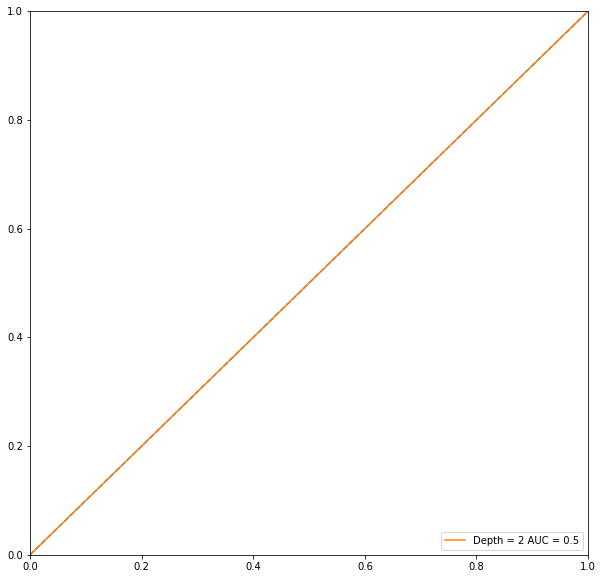

In [27]:
tree = DecisionTreeClassifier(max_depth=2, criterion='gini')
# Train Decision Tree Classifer
tree.fit(X_train, y_train)

#считаем вероятность второго класса
y_proba = tree.predict_proba(X_test)[:,1]

#roc_curve выдает fpr, tpr и threshold, последнее нам не нужно
fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label = 1)
roc_auc = auc(fpr, tpr)
roc_auc
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], "--") #пунктирная линия   
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(fpr,tpr, label="Depth = " + str(tree.max_depth) + " AUC = " + str(roc_auc))
plt.legend(loc = "lower right")
plt.show()

[Text(167.4, 163.07999999999998, 'X[158] <= 9.387\ngini = 0.469\nsamples = 8\nvalue = [5, 3]'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]')]

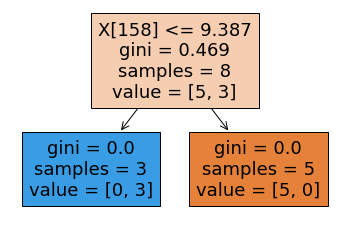

In [28]:
plot_tree(tree, filled=True)

Проблема в том, что из-за того, что данных очень мало, в при каждом создании дерева, выбираются разны признаки и в итоге roc_auc и признак, по которому идёт разделение, постоянно меняется. Поэтому я предлагаю использовать random forest, раз поставлена такая задача.

### RandomForestClassifier

In [29]:
forest = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=100)
forest.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

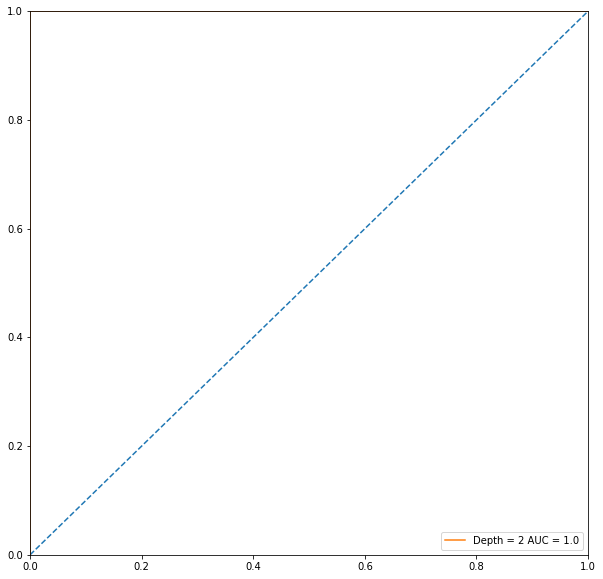

In [30]:
#считаем вероятность второго класса
y_proba = forest.predict_proba(X_test)[:,1]

#roc_curve выдает fpr, tpr и threshold, последнее нам не нужно
fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label = 1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], "--") #пунктирная линия   
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(fpr,tpr, label="Depth = " + str(tree.max_depth) + " AUC = " + str(roc_auc))
plt.legend(loc = "lower right")
plt.show()

Для такого дерева auc и признаки разделения уже не изменяются в зависимости от запуска

Лучшие признаки для разделения
1. feature: Fdft1; importance: 0.03
2. feature: Blnk; importance: 0.03
3. feature: Mnda; importance: 0.03
4. feature: A_52_P127513; importance: 0.03
5. feature: Gal3st1; importance: 0.03
6. feature: Lgals4; importance: 0.03
7. feature: Ttc39a; importance: 0.02
8. feature: Plxnb1; importance: 0.02
9. feature: Mup9; importance: 0.02
10. feature: Sgk1; importance: 0.02
11. feature: Tsnax; importance: 0.02
12. feature: A_52_P596360; importance: 0.02
13. feature: Pex14; importance: 0.02
14. feature: 2410076I21Rik; importance: 0.02
15. feature: Amn; importance: 0.02


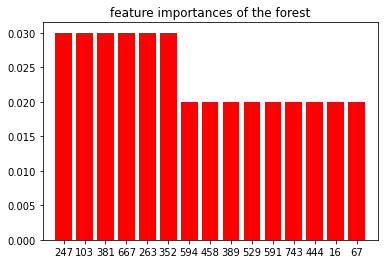

In [31]:
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

indices = indices[:15]

features = list(droped_df_cntrl_low.columns)

print("Лучшие признаки для разделения")

important_features_low = []
for i in range(len(indices)):
    if importances[indices[i]] > 0:
        important_features_low.append(features[indices[i]])
        print("{}. feature: {}; importance: {}".format(i+1, features[indices[i]], importances[indices[i]]))


# Plot the feature importances of the forest
plt.figure()
plt.title("feature importances of the forest")
plt.bar(range(15), importances[indices],
       color="r", align="center")
plt.xticks(range(15), indices)
plt.xlim([-1, 15])
plt.show()




### high_dose vs control

In [32]:
df_cntrl_high = pd.concat([control_undup.drop('mean', axis=1).set_index('gene'), \
                          high_undup.drop('mean', axis=1).set_index('gene')], \
                         ignore_index=False, axis=1)
df_cntrl_high = df_cntrl_high.T.reset_index()
df_cntrl_high

gene,index,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B22Rik,...,A_52_P98210,A_52_P98452,A_52_P987071,A_52_P987411,A_52_P988817,A_52_P989584,A_52_P99082,A_52_P996473,A_52_P997209,A_52_P997449
0,GSM658075,12.386,12.598,11.1325,7.974,6.284000,13.538,10.220,9.237,10.7825,...,6.223,9.341,10.798,5.799,6.941,6.520,5.998,5.901,7.734,10.070
1,GSM658076,12.374,12.480,10.7675,7.701,6.711000,13.635,10.472,8.496,10.8380,...,6.114,9.405,10.566,6.123,6.589,6.402,5.830,6.098,8.105,9.784
2,GSM658077,12.385,12.669,10.8120,8.227,6.524333,13.741,10.437,8.796,10.6050,...,6.179,9.578,10.533,6.002,6.731,6.553,5.913,6.142,7.841,9.009
3,GSM658078,12.722,12.764,10.9670,7.957,6.591667,13.737,10.417,8.866,10.9430,...,6.343,9.187,10.771,6.098,6.492,6.331,5.921,6.114,7.631,10.071
4,GSM658079,12.550,12.744,10.8690,7.868,6.627667,13.671,10.256,9.187,10.8770,...,5.914,9.404,10.691,5.941,6.483,6.237,5.972,5.856,7.893,9.762
5,GSM658080,12.471,12.315,10.8810,7.784,6.653000,13.016,10.614,9.476,10.7075,...,6.174,9.400,10.645,5.720,6.937,6.339,6.163,5.963,8.232,9.535
6,GSM658087,12.451,12.762,10.8200,7.888,6.521000,13.611,10.397,9.445,10.7945,...,6.142,9.387,10.832,5.848,6.668,6.066,6.077,6.205,7.763,9.428
7,GSM658088,12.554,12.734,11.3445,7.533,6.568667,13.459,10.436,9.003,10.7765,...,6.414,9.418,10.552,5.913,6.863,6.251,6.005,6.275,8.154,9.136
8,GSM658089,12.657,12.529,10.5980,8.224,6.772333,13.577,8.607,9.051,10.9705,...,6.242,9.668,10.773,5.772,6.496,6.261,5.928,6.366,7.703,9.890
9,GSM658090,12.281,12.601,11.0810,7.984,6.614667,13.214,10.700,8.379,10.8700,...,5.981,9.682,10.839,5.876,6.781,5.929,6.237,5.957,7.878,10.302


In [33]:
df_cntrl_high['index'] = [0 if name in controls else 1 for name in df_cntrl_high['index']]
df_cntrl_high = df_cntrl_high.rename(columns={'index':'label'})
df_cntrl_high

gene,label,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B22Rik,...,A_52_P98210,A_52_P98452,A_52_P987071,A_52_P987411,A_52_P988817,A_52_P989584,A_52_P99082,A_52_P996473,A_52_P997209,A_52_P997449
0,0,12.386,12.598,11.1325,7.974,6.284000,13.538,10.220,9.237,10.7825,...,6.223,9.341,10.798,5.799,6.941,6.520,5.998,5.901,7.734,10.070
1,0,12.374,12.480,10.7675,7.701,6.711000,13.635,10.472,8.496,10.8380,...,6.114,9.405,10.566,6.123,6.589,6.402,5.830,6.098,8.105,9.784
2,0,12.385,12.669,10.8120,8.227,6.524333,13.741,10.437,8.796,10.6050,...,6.179,9.578,10.533,6.002,6.731,6.553,5.913,6.142,7.841,9.009
3,0,12.722,12.764,10.9670,7.957,6.591667,13.737,10.417,8.866,10.9430,...,6.343,9.187,10.771,6.098,6.492,6.331,5.921,6.114,7.631,10.071
4,0,12.550,12.744,10.8690,7.868,6.627667,13.671,10.256,9.187,10.8770,...,5.914,9.404,10.691,5.941,6.483,6.237,5.972,5.856,7.893,9.762
5,0,12.471,12.315,10.8810,7.784,6.653000,13.016,10.614,9.476,10.7075,...,6.174,9.400,10.645,5.720,6.937,6.339,6.163,5.963,8.232,9.535
6,1,12.451,12.762,10.8200,7.888,6.521000,13.611,10.397,9.445,10.7945,...,6.142,9.387,10.832,5.848,6.668,6.066,6.077,6.205,7.763,9.428
7,1,12.554,12.734,11.3445,7.533,6.568667,13.459,10.436,9.003,10.7765,...,6.414,9.418,10.552,5.913,6.863,6.251,6.005,6.275,8.154,9.136
8,1,12.657,12.529,10.5980,8.224,6.772333,13.577,8.607,9.051,10.9705,...,6.242,9.668,10.773,5.772,6.496,6.261,5.928,6.366,7.703,9.890
9,1,12.281,12.601,11.0810,7.984,6.614667,13.214,10.700,8.379,10.8700,...,5.981,9.682,10.839,5.876,6.781,5.929,6.237,5.957,7.878,10.302


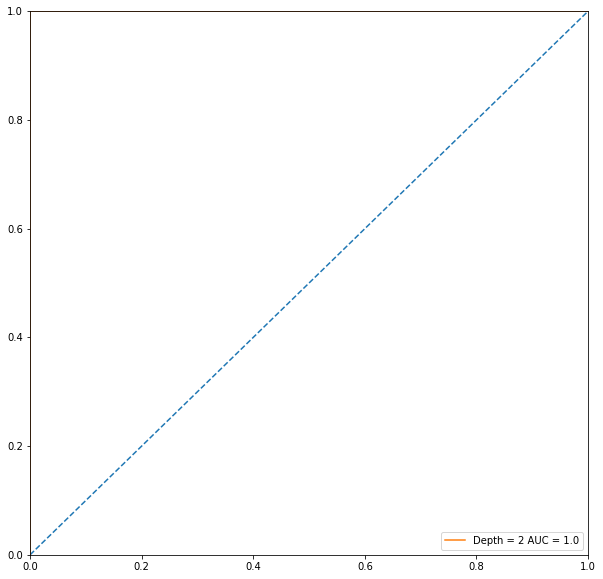

In [34]:
droped_df_cntrl_high = variance_threshold_selector(df_cntrl_high, 0.24)

X = droped_df_cntrl_high.drop("label", axis = 1).values
y = droped_df_cntrl_high["label"].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)

forest = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=100)
forest.fit(X, y)

#считаем вероятность второго класса
y_proba = forest.predict_proba(X_test)[:,1]

#roc_curve выдает fpr, tpr и threshold, последнее нам не нужно
fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label = 1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], "--") #пунктирная линия   
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(fpr,tpr, label="Depth = " + str(tree.max_depth) + " AUC = " + str(roc_auc))
plt.legend(loc = "lower right")
plt.show()

Лучшие признаки для разделения
1. feature: Trem2; importance: 0.03333333333333333
2. feature: Crybb3; importance: 0.033
3. feature: A_51_P381170; importance: 0.03
4. feature: Tyrobp; importance: 0.03
5. feature: Unkl; importance: 0.026666666666666665
6. feature: Sult5a1; importance: 0.022857142857142857
7. feature: Raet1e; importance: 0.02210204081632653
8. feature: A_52_P651784; importance: 0.02
9. feature: Syt10; importance: 0.02
10. feature: Retsat; importance: 0.02
11. feature: Treh; importance: 0.02
12. feature: Srd5a2; importance: 0.02
13. feature: Casp4; importance: 0.02
14. feature: Mast2; importance: 0.02
15. feature: H2-Eb1; importance: 0.017142857142857144


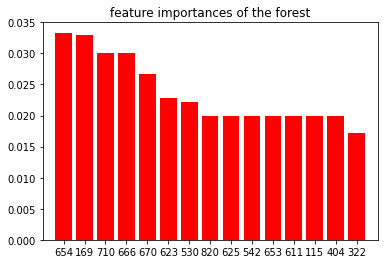

In [35]:
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

indices = indices[:15]

features = list(droped_df_cntrl_high.columns)

print("Лучшие признаки для разделения")

important_features_high = []
for i in range(len(indices)):
    if importances[indices[i]] > 0:
        important_features_high.append(features[indices[i]])
        print("{}. feature: {}; importance: {}".format(i+1, features[indices[i]], importances[indices[i]]))


# Plot the feature importances of the forest
plt.figure()
plt.title("feature importances of the forest")
plt.bar(range(15), importances[indices],
       color="r", align="center")
plt.xticks(range(15), indices)
plt.xlim([-1, 15])
plt.show()




In [36]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

print(intersection(important_features_high, important_features_low))

[]


Признаки в деревьях не совпали!